<a href="https://colab.research.google.com/github/Vorlde/-WQU-MScFE-Capstone-Project/blob/main/Trading_ols.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install dill
! pip install statsmodels
!pip install hurst
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller as ADF_test
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow.keras.models import load_model

# Define the file path for saving the model
file_path = "/content/drive/My Drive/Model/hedge_ratio_model.h5"

# To load the model later
loaded_model = load_model(file_path)


In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

from statsmodels.tsa.stattools import coint

from scipy import stats

import lzma
import dill as pickle

def save_pickle(path,obj):
    with lzma.open(path,"wb") as fp:
        pickle.dump(obj,fp)

def load_pickle(path):
    with lzma.open(path,"rb") as fp:
        file = pickle.load(fp)
    return file

def clean_data(ticker_dfs,tickers):
    intraday_range = ticker_dfs[tickers[0]].index
    for inst in tickers:
        ticker_dfs[inst] = ticker_dfs[inst].reindex(intraday_range)
    closes = []

    for tk in tickers:
        close = ticker_dfs[tk].close
        closes.append(close)

    pricing = pd.concat(closes,axis = 1)
    pricing.columns = tickers

    return pricing




def get_pca_features(ret_df,N_PRIN_COMPONENTS =10):

    pca = PCA(n_components=N_PRIN_COMPONENTS)
    pca.fit(ret_df)

    # Extract factor loadings
    factor_loadings = pca.components_.T  # Transpose the components matrix

    # Create a DataFrame with the correct orientation
    factor_loadings_df = pd.DataFrame(factor_loadings, index=ret_df.columns, columns=[f'Factor {i+1}' for i in range(N_PRIN_COMPONENTS)])

    X = preprocessing.StandardScaler().fit_transform(pca.components_.T)

    return X

def create_clusters(X,index):
    clf = DBSCAN(eps=1.5, min_samples=3)

    print(clf)

    clf.fit(X)
    labels = clf.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("\nClusters discovered: %d" % n_clusters_)

    clustered = clf.labels_

    clustered_series = pd.Series(index=index, data=clustered.flatten())
    clustered_series = clustered_series[clustered_series != -1]

    return clustered_series


def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs



def get_coint_pairs(prices,clustered_series):

    valid_tickers = clustered_series.index.intersection(prices.columns)
    clustered_series = clustered_series.loc[valid_tickers]

    CLUSTER_SIZE_LIMIT = 9999
    counts = clustered_series.value_counts()
    ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]

    cluster_dict = {}
    for i, which_clust in enumerate(ticker_count_reduced.index):
        tickers = clustered_series[clustered_series == which_clust].index
        score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
            prices[tickers]
        )
        cluster_dict[which_clust] = {}
        cluster_dict[which_clust]['score_matrix'] = score_matrix
        cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
        cluster_dict[which_clust]['pairs'] = pairs

    pairs = []
    for clust in cluster_dict.keys():
        pairs.extend(cluster_dict[clust]['pairs'])

    return pairs


def get_data():
    data_path = "/content/drive/My Drive/constituents.csv"
    dfs_path = "/content/drive/My Drive/new_dfs.obj"

    ticker_dfs = load_pickle(dfs_path)
    snp_data = pd.read_csv(data_path)
    tickers = []

    for i in range(499):
      tickers.append(snp_data.Symbol[i])

    tickers.remove("BF.B")
    tickers.remove("BRK.B")
    tickers.remove("CPAY")
    tickers.remove("DAY")
    tickers.remove("GEV")
    tickers.remove("SOLV")

    return tickers,ticker_dfs

In [5]:
tickers,ticker_dfs = get_data()

In [6]:
def generate_trading_data_blocks(df, month, year):
    if month == 12:
        month = 1
        year += 1
    else:
        month += 1

    next_month_data = df[(df.index.year == year) & (df.index.month == month)]
    return next_month_data


def find_cointegrated_pairs(data):
    # Placeholder function for cointegration check
    # Implement the actual cointegration logic here
    score_matrix = np.zeros((data.shape[1], data.shape[1]))
    pvalue_matrix = np.ones((data.shape[1], data.shape[1]))
    pairs = []

    for i in range(data.shape[1]):
        for j in range(i+1, data.shape[1]):
            result = sm.tsa.coint(data.iloc[:, i], data.iloc[:, j])
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:  # Cointegrated pair found
                pairs.append((data.columns[i], data.columns[j]))

    return score_matrix, pvalue_matrix, pairs


def calculate_monthly_clusters(monthly_data):
    """
    Calculate clusters for the given month.

    """
    ret_df = monthly_data.pct_change().round(4).fillna(0)
    X = get_pca_features(ret_df)
    clustered_series = create_clusters(X, ret_df.columns)

    return clustered_series


def yield_monthly_data(data):
    for (year, month), monthly_data in data.groupby([data.index.year, data.index.month]):
        yield year, month, monthly_data

In [7]:

import statsmodels.api as sm
from hurst import compute_Hc  # Assuming you have a function to compute the Hurst exponent
from statsmodels.tools.tools import add_constant
from scipy.stats import skew, kurtosis

def add_stationary(spread_normalized):

    rolling_volatility = spread_normalized[:500].rolling(window=10).std()
    hurst_exponent = compute_Hc(spread_normalized[:500])[0]  # Hurst exponent

    skewness = skew(spread_normalized[:500])
    kurtosis_value = kurtosis(spread_normalized[:500])


    # Ensure spread_lagged starts from the second element to align with spread_diff which starts from the second element due to differencing and shifting
    spread_lagged = spread_normalized.shift(1).dropna()
    spread_diff = spread_normalized.diff().dropna()  # First difference to get spread_diff

    # Make sure indices are aligned by reindexing spread_diff to match spread_lagged
    spread_diff = spread_diff.reindex(spread_lagged.index)
    spread_diff += 1e-8

    # Now perform your regression with aligned indices
    model = sm.OLS(np.log(np.abs(spread_diff)), add_constant(spread_lagged))
    result = model.fit()
    phi = result.params[0]


    spread_normalized = spread_normalized[:500]  # Normalized spread

    features_df = pd.DataFrame({
        'spread_normalized': spread_normalized,
        'rolling_volatility': rolling_volatility[:500],
        'hurst_exponent': np.repeat(hurst_exponent, rolling_volatility.shape[0]),
    })

    # Mean Reversion Speed calculated as the absolute value of phi
    mean_reversion_speed = np.abs(phi)

    # Calculate half-life from the decay factor
    half_life = -np.log(2) / np.log(np.abs(phi))


    features_df['half_life'] = np.repeat(half_life, len(features_df))
    features_df['mean_reversion_speed'] = np.repeat(mean_reversion_speed, len(features_df))
    features_df['skewness'] = np.repeat(skewness, len(features_df))
    features_df['kurtosis'] = np.repeat(kurtosis_value, len(features_df))

    return features_df




def process_pair(pair, prices):
    s1, s2 = pair

    datax = prices[s1]
    datay = prices[s2]

    # Calculate hedge ratio using the first 500 data points
    hedge_ratio = sm.OLS(datax[:500], sm.add_constant(datay[:500])).fit().params[1]

    # Calculate the spread based on the hedge ratio
    spread = datax - hedge_ratio * datay

    # Calculate mean and standard deviation using the first 500 data points
    initial_mean = spread[:500].mean()
    initial_std = spread[:500].std()

    # Create a DataFrame with the calculated columns
    df = pd.DataFrame({
        'datax': datax,
        'datay': datay,
        'hedge_ratio': hedge_ratio,
        'spread': spread,
        'rolling_mean': initial_mean,
        'rolling_std': initial_std
    })

    # Normalized spread
    spread_normalized = (spread - initial_mean) / initial_std

    # Plotting the normalized spread along with mean and ±2 std lines
    plt.figure(figsize=(15, 7))
    spread_normalized = spread_normalized.reset_index(drop=True)
    plt.title(f'Z-Scores for {s1} and {s2} Across Training Period')
    spread_normalized.plot(label='Normalized Spread')
    plt.axhline(y=0, color='black', linestyle='--', label='Mean')
    plt.axhline(y=2, color='red', linestyle='--', label='+2 Std Dev')
    plt.axhline(y=-2, color='green', linestyle='--', label='-2 Std Dev')
    plt.legend()
    plt.show()

    return df



import statsmodels.api as sm

def calculate_hedge_ratio(x, y):
    x = sm.add_constant(x)  # Adding a constant term for the intercept
    model = sm.OLS(y, x).fit()
    return model.params[1]  # Return

def process_pair(pair, prices, window=100):
    s1, s2 = pair
    datax = prices[s1]
    datay = prices[s2]

    hedge_ratios = []
    for start in range(len(datax) - window + 1):
        end = start + window
        x_window = datax[start:end]
        y_window = datay[start:end]
        hedge_ratio = calculate_hedge_ratio(x_window, y_window)
        hedge_ratios.append(hedge_ratio)

    hedge_ratios = pd.Series(hedge_ratios, index=datax.index[window-1:])
    hedge_ratios = hedge_ratios.reindex(datax.index).fillna(method='bfill')

    spread = datax - hedge_ratios * datay
    rolling_mean = spread.rolling(window=window).mean()
    rolling_std = spread.rolling(window=window).std()
    upper_threshold_level = rolling_mean + 2 * rolling_std
    lower_threshold_level = rolling_mean - 2 * rolling_std

    # Calculate spread
    spread = datax - hedge_ratios * datay

    # Calculate rolling mean and rolling standard deviation
    rolling_mean = spread.rolling(window=window).mean()
    rolling_std = spread.rolling(window=window).std()

    # Calculate upper and lower threshold levels
    upper_threshold_level = rolling_mean + 2 * rolling_std
    lower_threshold_level = rolling_mean - 2 * rolling_std

    # Create DataFrame
    result_df = pd.DataFrame({
        's1': datax,
        's2': datay,
        'spread': spread,
        'hedge_ratios': hedge_ratios,
        'rolling_mean': rolling_mean,
        'upper_threshold_level': upper_threshold_level,
        'lower_threshold_level': lower_threshold_level
    })

    return result_df



In [8]:
# tickers,ticker_dfs = get_data()
intraday_dfs = ticker_dfs.copy()
prices = clean_data(intraday_dfs, tickers)

In [9]:
import numpy as np
import pandas as pd

class TradingAgent:
    def __init__(self, initial_capital=100000):
        self.initial_capital = initial_capital
        self.per_pair_capital = initial_capital

    def calculate_hedge_ratio(self, x, y):
        x = sm.add_constant(x)  # Adding a constant term for the intercept
        model = sm.OLS(y, x).fit()
        return model.params[1]  # Return the coefficient of x, which is the hedge ratio

    def process_pair(self, pair, prices, window=100):
        s1, s2 = pair
        datax = prices[s1]
        datay = prices[s2]

        hedge_ratios = []
        for start in range(len(datax) - window + 1):
            end = start + window
            x_window = datax[start:end]
            y_window = datay[start:end]
            hedge_ratio = self.calculate_hedge_ratio(x_window, y_window)
            hedge_ratios.append(hedge_ratio)

        hedge_ratios = pd.Series(hedge_ratios, index=datax.index[window-1:])
        hedge_ratios = hedge_ratios.reindex(datax.index).fillna(method='bfill')

        spread = datax - hedge_ratios * datay
        rolling_mean = spread.rolling(window=window).mean()
        rolling_std = spread.rolling(window=window).std()
        upper_threshold_level = rolling_mean + 2 * rolling_std
        lower_threshold_level = rolling_mean - 2 * rolling_std

        result_df = pd.DataFrame({
            's1': datax,
            's2': datay,
            'spread': spread,
            'hedge_ratios': hedge_ratios,
            'rolling_mean': rolling_mean,
            'upper_threshold_level': upper_threshold_level,
            'lower_threshold_level': lower_threshold_level
        })

        result_df['returns'] = 0.0
        result_df['returns_pct'] = 0.0
        result_df['capital'] = self.initial_capital
        result_df['action'] = np.nan

        return result_df

    def trade(self, result_df):
        capital = self.initial_capital
        positions = 0
        entry_spread = 0
        entry_s1 = 0
        entry_s2 = 0
        entry_qty_s1 = 0
        entry_qty_s2 = 0
        last_capital_update_index = 0
        stop_loss_threshold = 0.01  # 1% stop loss

        result_df['returns'] = 0.0
        result_df['returns_pct'] = 0.0
        result_df['capital'] = capital
        result_df['cap_ret'] = 0.0

        for i in range(1, len(result_df)):  # Start from the second row
            # Update capital for all rows till the current row
            if i > last_capital_update_index:
                result_df.loc[result_df.index[last_capital_update_index:i], 'capital'] = capital

            # Calculate the required capital to trade one pair
            hedge_ratio = abs(result_df['hedge_ratios'].iloc[i])
            required_capital_per_pair = (result_df['s1'].iloc[i] + hedge_ratio * result_df['s2'].iloc[i])

            # Calculate the maximum quantity that can be traded based on available capital
            max_qty = self.per_pair_capital // required_capital_per_pair

            if positions == 0:
                if result_df['spread'].iloc[i] > result_df['upper_threshold_level'].iloc[i]:
                    positions = -1  # Sell position
                    entry_spread = result_df['spread'].iloc[i]
                    entry_s1 = result_df['s1'].iloc[i]
                    entry_s2 = result_df['s2'].iloc[i]
                    entry_qty_s1 = max_qty
                    entry_qty_s2 = max_qty * hedge_ratio
                    result_df.at[result_df.index[i], 'action'] = 'Sell'
                    last_capital_update_index = i
                elif result_df['spread'].iloc[i] < result_df['lower_threshold_level'].iloc[i]:
                    positions = 1  # Buy position
                    entry_spread = result_df['spread'].iloc[i]
                    entry_s1 = result_df['s1'].iloc[i]
                    entry_s2 = result_df['s2'].iloc[i]
                    entry_qty_s1 = max_qty
                    entry_qty_s2 = max_qty * hedge_ratio
                    result_df.at[result_df.index[i], 'action'] = 'Buy'
                    last_capital_update_index = i

            elif positions == -1:
                if result_df['spread'].iloc[i] <= result_df['rolling_mean'].iloc[i]:
                    # Calculate returns for sell position
                    returns = (entry_qty_s1 * (entry_s1 - result_df['s1'].iloc[i]) -
                               entry_qty_s2 * (result_df['s2'].iloc[i] - entry_s2))
                    returns_pct = returns / required_capital_per_pair
                    capital += returns
                    result_df.at[result_df.index[i], 'returns'] = returns
                    result_df.at[result_df.index[i], 'returns_pct'] = returns_pct
                    result_df.at[result_df.index[i], 'capital'] = capital
                    result_df.at[result_df.index[i], 'action'] = 'Close Sell'
                    positions = 0  # Close position
                    last_capital_update_index = i
                else:
                    # Check stop loss for sell position
                    loss = (entry_qty_s1 * (result_df['s1'].iloc[i] - entry_s1) +
                            entry_qty_s2 * (entry_s2 - result_df['s2'].iloc[i]))
                    if loss >= stop_loss_threshold * self.per_pair_capital:
                        capital -= loss
                        returns_pct = -loss / required_capital_per_pair
                        result_df.at[result_df.index[i], 'returns'] = -loss
                        result_df.at[result_df.index[i], 'returns_pct'] = returns_pct
                        result_df.at[result_df.index[i], 'capital'] = capital
                        result_df.at[result_df.index[i], 'action'] = 'Stop Loss Sell'
                        positions = 0  # Close position due to stop loss
                        last_capital_update_index = i

            elif positions == 1:
                if result_df['spread'].iloc[i] >= result_df['rolling_mean'].iloc[i]:
                    # Calculate returns for buy position
                    returns = (entry_qty_s1 * (result_df['s1'].iloc[i] - entry_s1) +
                               entry_qty_s2 * (result_df['s2'].iloc[i] - entry_s2))
                    returns_pct = returns / required_capital_per_pair
                    capital += returns
                    result_df.at[result_df.index[i], 'returns'] = returns
                    result_df.at[result_df.index[i], 'returns_pct'] = returns_pct
                    result_df.at[result_df.index[i], 'capital'] = capital
                    result_df.at[result_df.index[i], 'action'] = 'Close Buy'
                    positions = 0  # Close position
                    last_capital_update_index = i
                else:
                    # Check stop loss for buy position
                    loss = (entry_qty_s1 * (entry_s1 - result_df['s1'].iloc[i]) +
                            entry_qty_s2 * (entry_s2 - result_df['s2'].iloc[i]))
                    if loss >= stop_loss_threshold * self.per_pair_capital:
                        capital -= loss
                        returns_pct = -loss / required_capital_per_pair
                        result_df.at[result_df.index[i], 'returns'] = -loss
                        result_df.at[result_df.index[i], 'returns_pct'] = returns_pct
                        result_df.at[result_df.index[i], 'capital'] = capital
                        result_df.at[result_df.index[i], 'action'] = 'Stop Loss Buy'
                        positions = 0  # Close position due to stop loss
                        last_capital_update_index = i

        # Update capital for the remaining rows
        result_df.loc[result_df.index[last_capital_update_index:], 'capital'] = capital

        # Calculate cumulative return on initial capital
        result_df['cap_ret'] = result_df['capital'] / self.initial_capital - 1

        return result_df


    def visualize_spread(self, result_df):
        plt.figure(figsize=(14, 7))

        plt.plot(result_df.index, result_df['spread'], label='Spread')
        plt.plot(result_df.index, result_df['rolling_mean'], label='Rolling Mean', linestyle='--')
        plt.plot(result_df.index, result_df['upper_threshold_level'], label='Upper Threshold', linestyle='--')
        plt.plot(result_df.index, result_df['lower_threshold_level'], label='Lower Threshold', linestyle='--')

        plt.fill_between(result_df.index, result_df['upper_threshold_level'], result_df['lower_threshold_level'], color='grey', alpha=0.3)

        # Add markers for actions
        buys = result_df[result_df['action'] == 'Buy']
        sells = result_df[result_df['action'] == 'Sell']
        close_buys = result_df[result_df['action'] == 'Close Buy']
        close_sells = result_df[result_df['action'] == 'Close Sell']

        plt.scatter(buys.index, buys['spread'] + 0.02, color='green', marker='^', s=100, label='Buy')  # Offset buys
        plt.scatter(sells.index, sells['spread'] - 0.02, color='red', marker='v', s=100, label='Sell')  # Offset sells
        plt.scatter(close_buys.index, close_buys['spread'], color='black', marker='o', s=100, label='Close Buy')
        plt.scatter(close_sells.index, close_sells['spread'], color='black', marker='x', s=100, label='Close Sell')

        plt.title('Spread with Rolling Mean and Threshold Levels')
        plt.xlabel('Time')
        plt.ylabel('Spread')
        plt.legend()
        plt.grid(True)
        plt.show()


    def calculate_metrics(self, result_df):
        # Filter out the rows where trades were closed
        closed_trades = result_df[result_df['action'].isin(['Close Buy', 'Close Sell', 'Stop Loss Buy', 'Stop Loss Sell'])]

        # Calculate the returns on closed trades
        trade_returns = closed_trades['returns_pct']

        # Calculate the average return per trade
        avg_trade_return = trade_returns.mean()

        # Calculate the standard deviation of returns per trade
        std_trade_return = trade_returns.std()

        # Calculate the Sharpe ratio
        sharpe_ratio = (avg_trade_return / std_trade_return) * np.sqrt(252)  # Assuming 252 trading days in a year

        # Calculate cumulative returns
        cumulative_return = result_df['cap_ret'].iloc[-1]

        metrics = {
            'Average Trade Return': avg_trade_return,
            'Standard Deviation of Trade Returns': std_trade_return,
            'Sharpe Ratio': sharpe_ratio,
            'Cumulative Return': cumulative_return
        }

        return metrics






Clustering for 3 2023
DBSCAN(eps=1.5, min_samples=3)

Clusters discovered: 6
0 ('MMM', 'BAC')


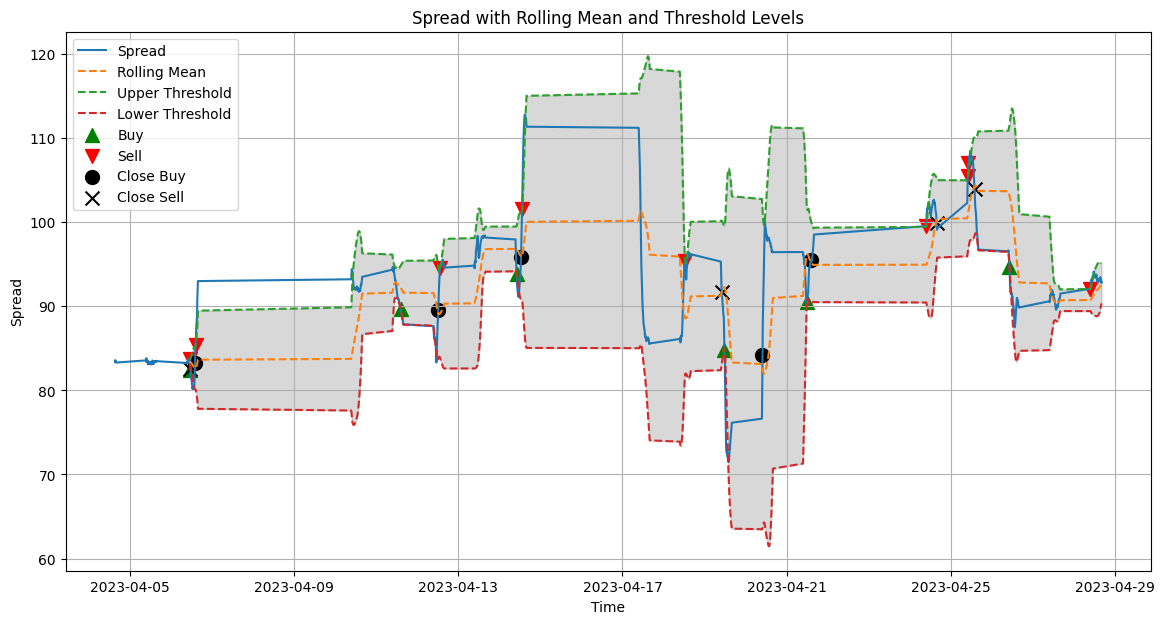

1 ('MMM', 'JPM')


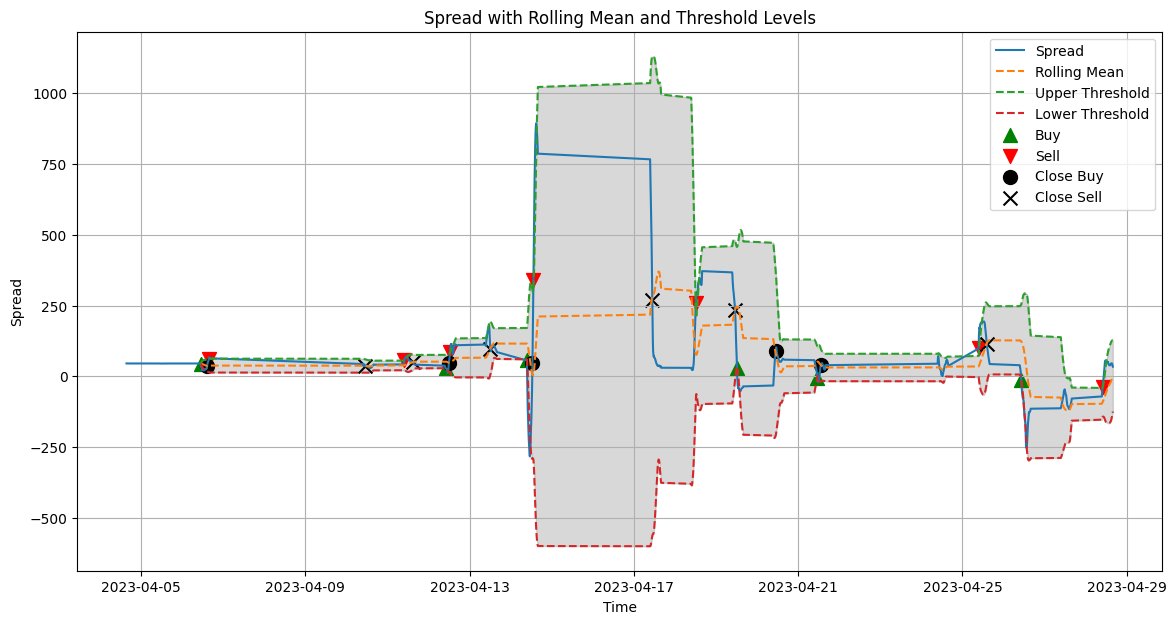

2 ('AAPL', 'DIS')


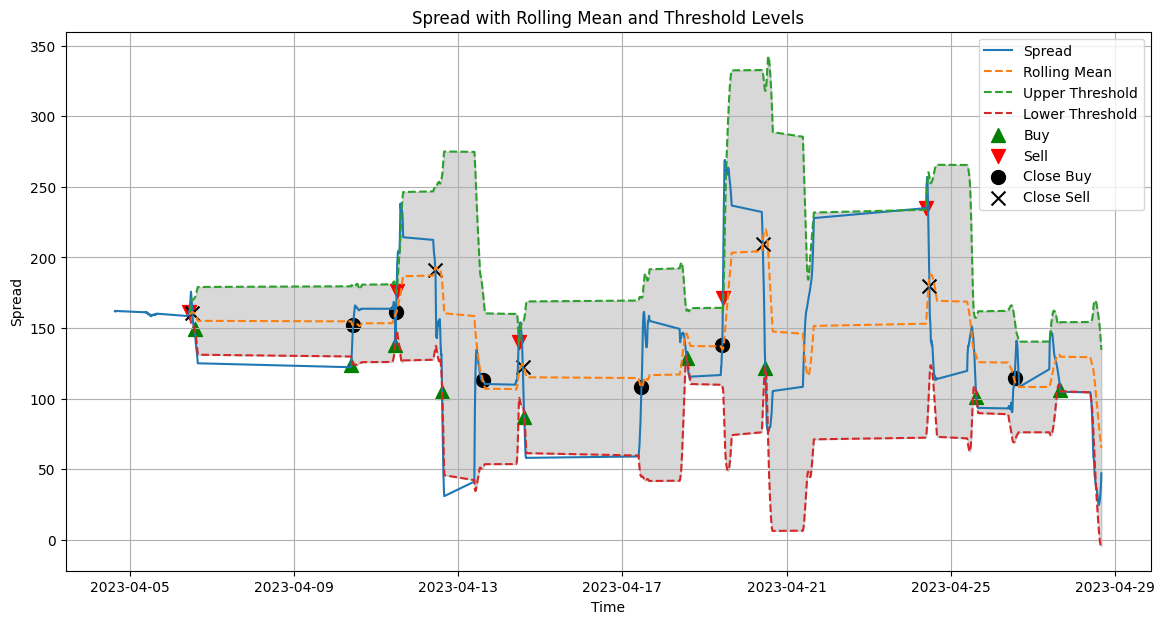

3 ('KO', 'COST')


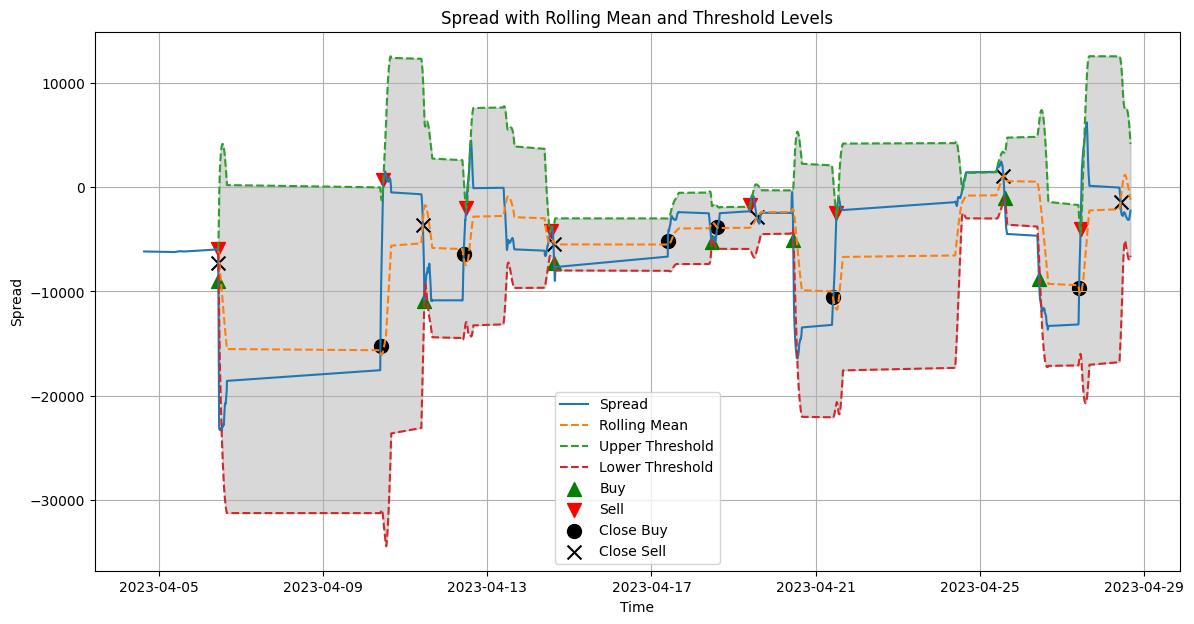

4 ('KO', 'MSFT')


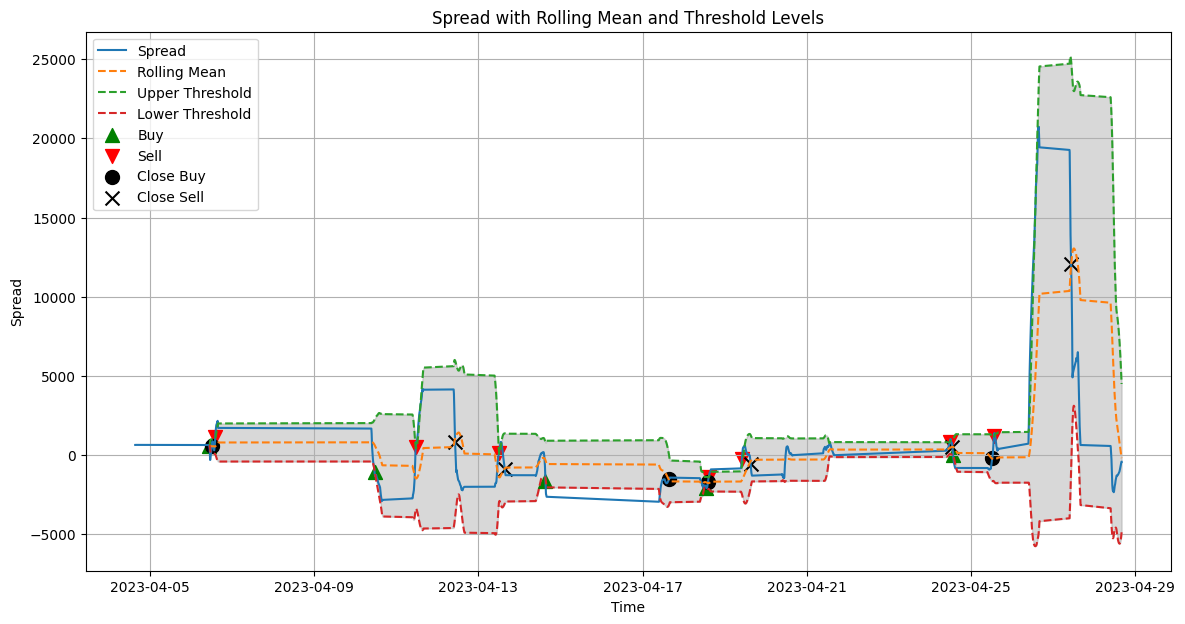

5 ('KO', 'PYPL')


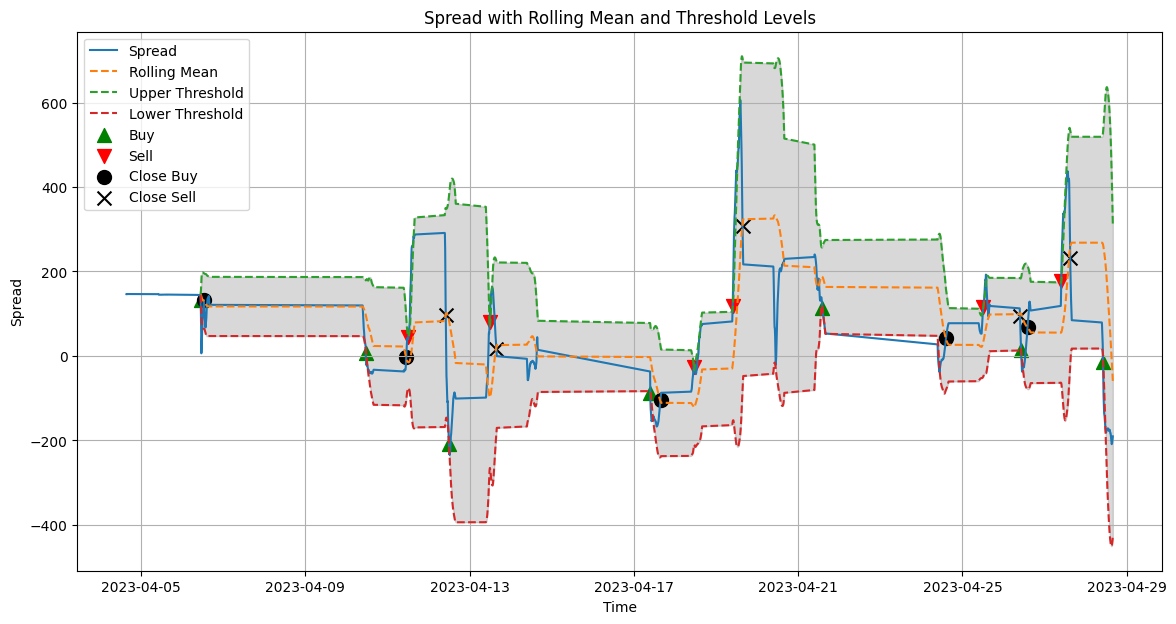

6 ('KO', 'PFE')


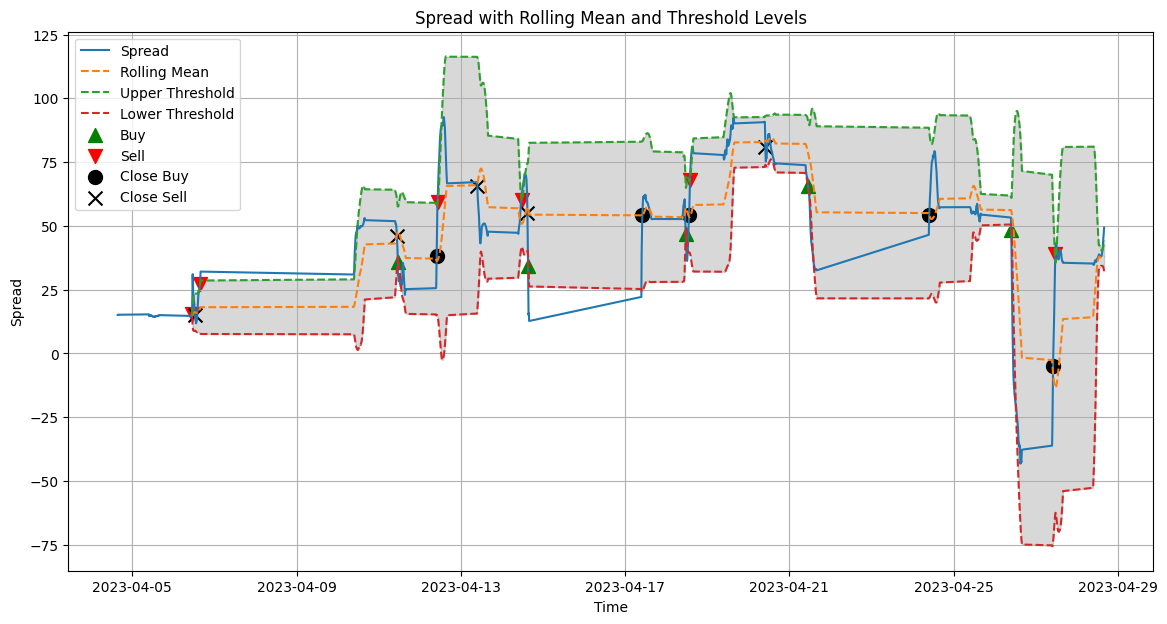

7 ('KO', 'O')


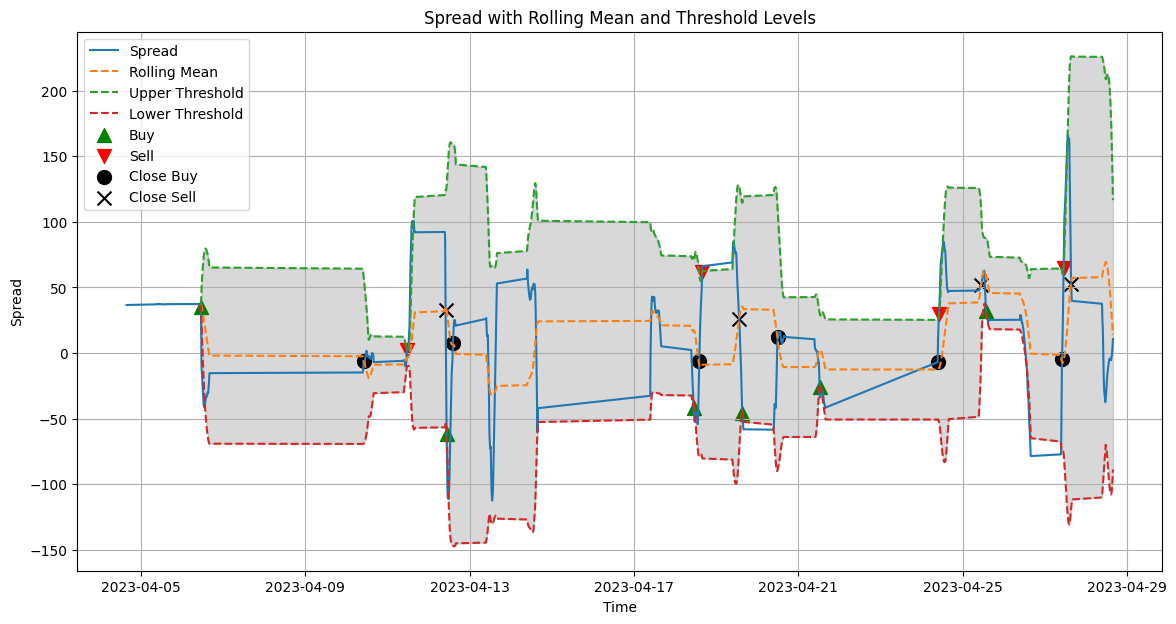

8 ('KO', 'VZ')


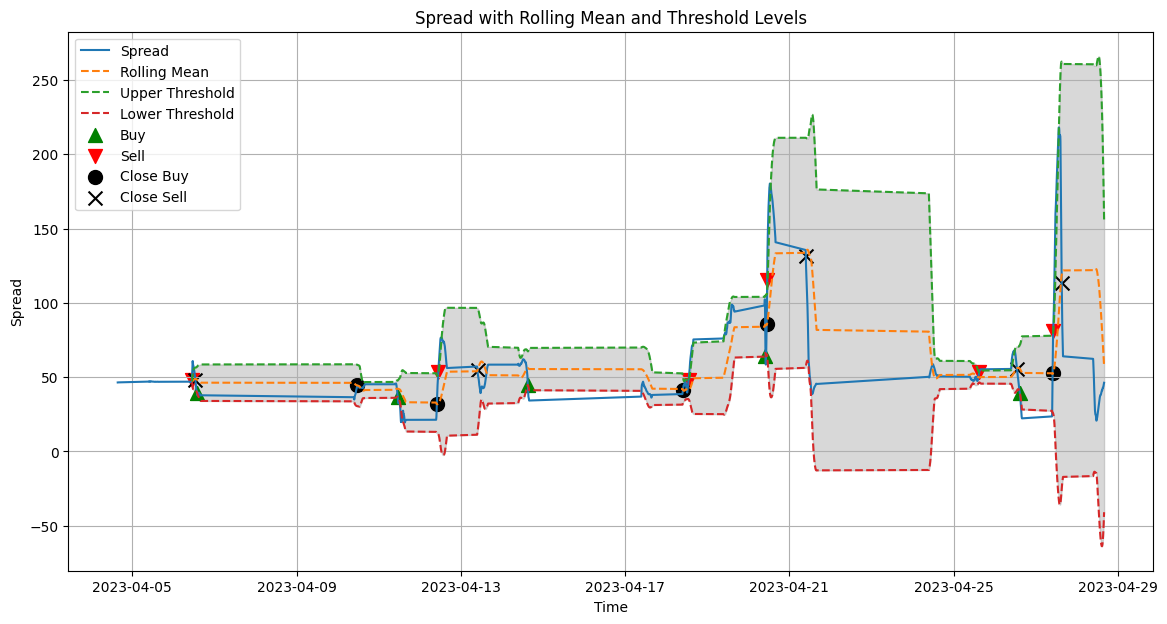

9 ('KO', 'DIS')


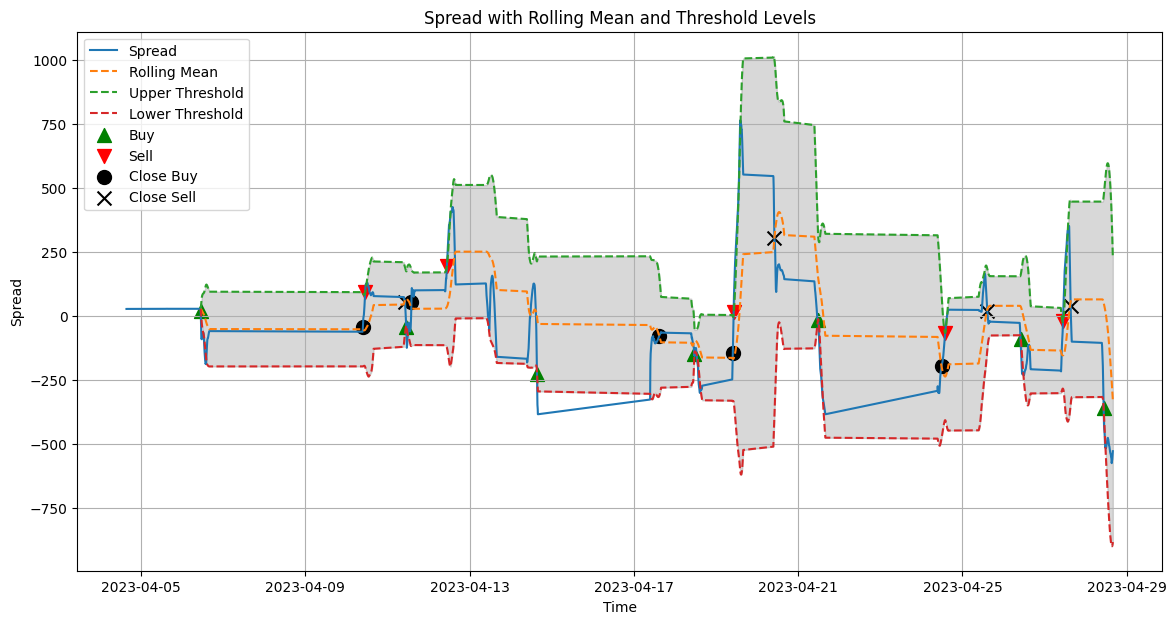

Monthly Trade Metrics:
Average Trade Return: -1.0329399579771819
Standard Deviation of Trade Returns: 5.4709804773523425
Sharpe Ratio: -2.9971617621911624
Cumulative Return: 0.0
                          s1       s2       spread  hedge_ratios  \
2023-04-06 10:50:00   61.152  467.429 -7300.949129     15.750202   
2023-04-06 11:25:00   96.244   26.981    82.563804      0.507031   
2023-04-06 12:15:00   61.259  285.120   565.119535     -1.767188   
2023-04-06 12:35:00   61.245   39.479    15.016390      1.170967   
2023-04-06 12:40:00  163.910   99.832   160.768953      0.031463   
...                      ...      ...          ...           ...   
2023-04-27 15:00:00   62.261   74.130   230.852947     -2.274274   
2023-04-27 15:10:00   62.217   36.523   113.354041     -1.400133   
2023-04-27 15:15:00   62.246   99.553    40.548416      0.217950   
2023-04-27 15:30:00   62.139   59.340    52.626998      0.160297   
2023-04-28 10:10:00   62.251  488.310 -1433.155086      3.062411   

     

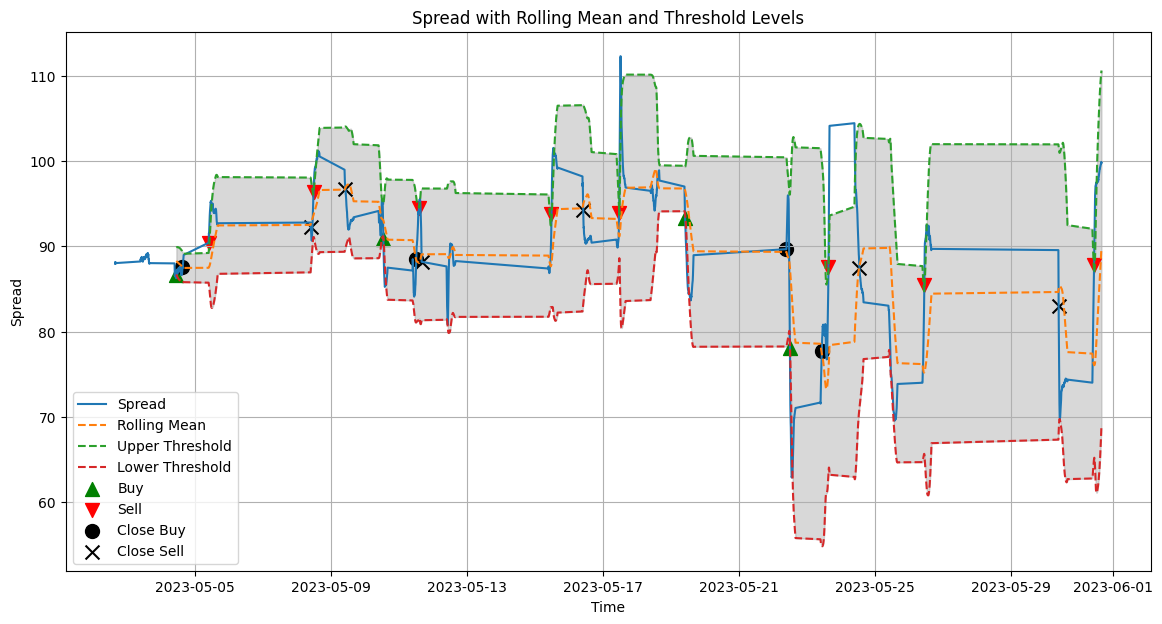

1 ('BAC', 'KO')


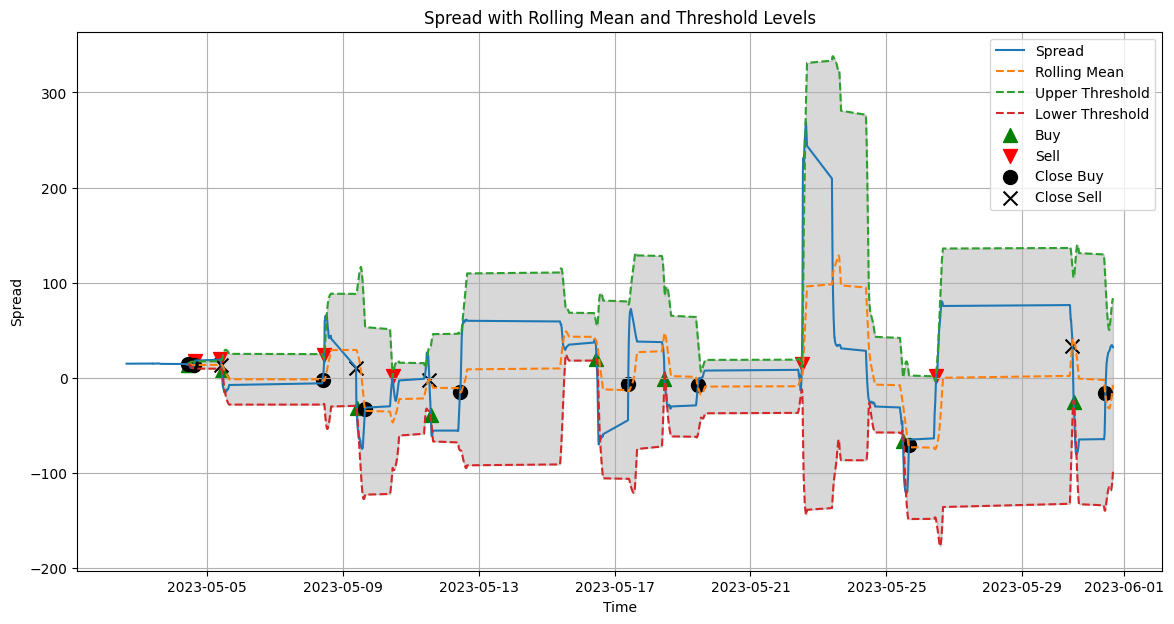

2 ('BAC', 'NKE')


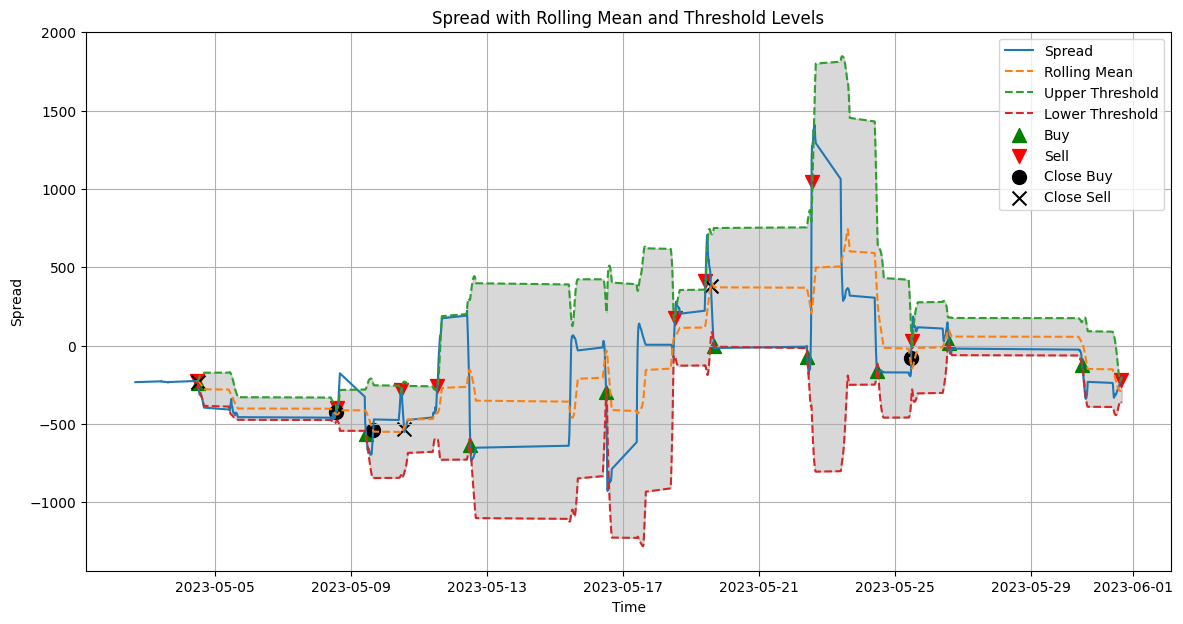

3 ('BAC', 'PFE')


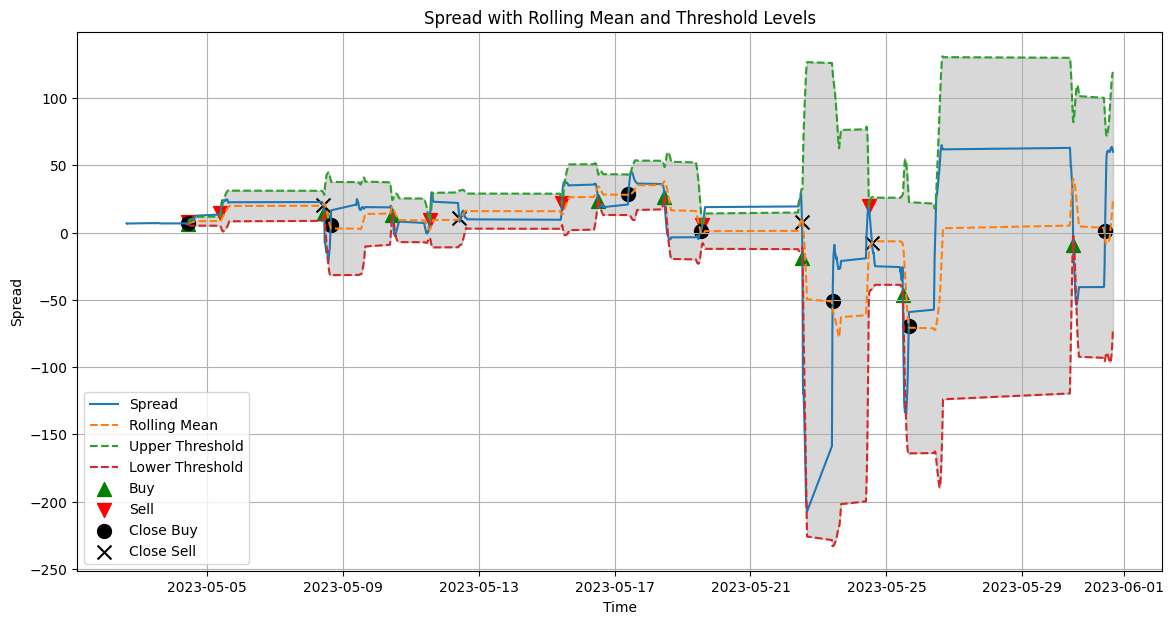

4 ('KO', 'OXY')


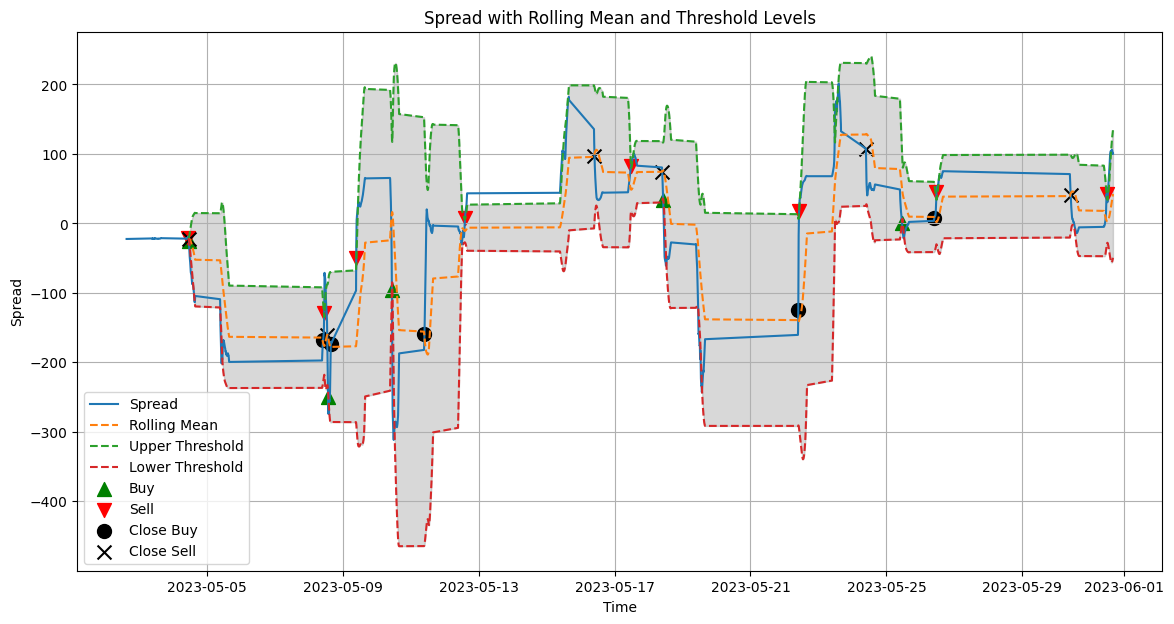

5 ('XOM', 'PFE')


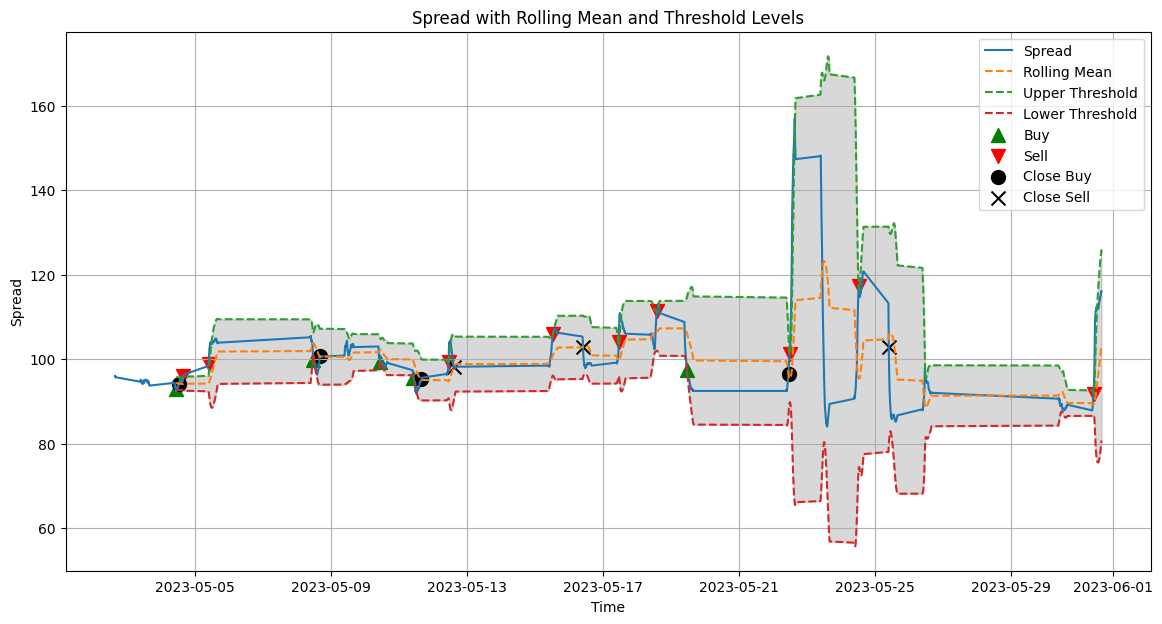

6 ('NKE', 'OXY')


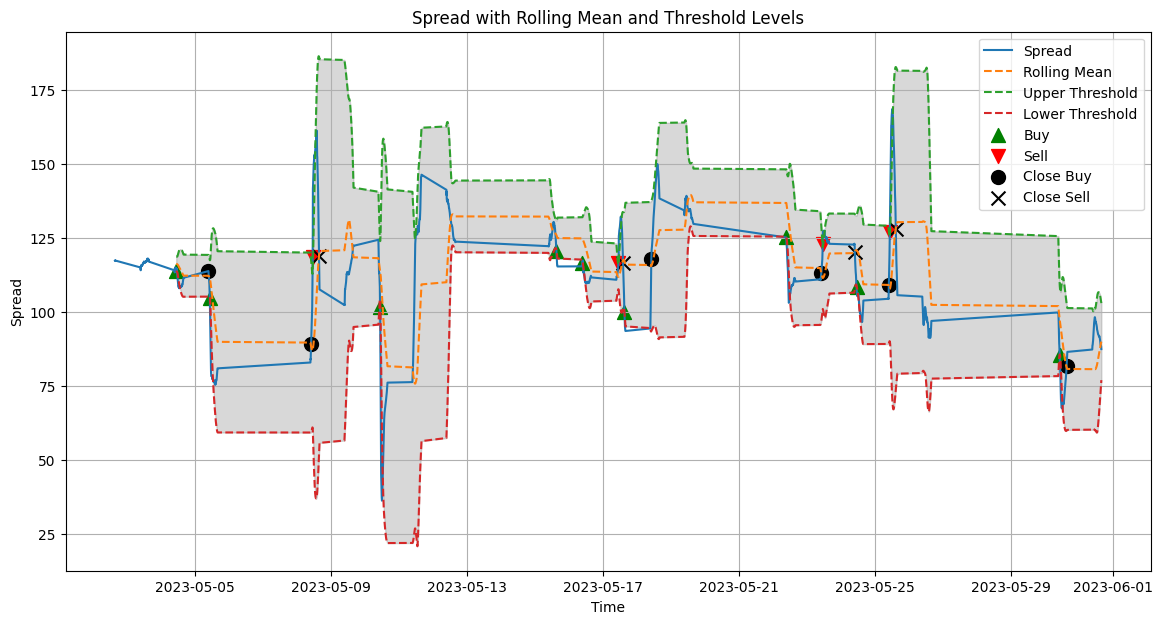

7 ('NKE', 'PFE')


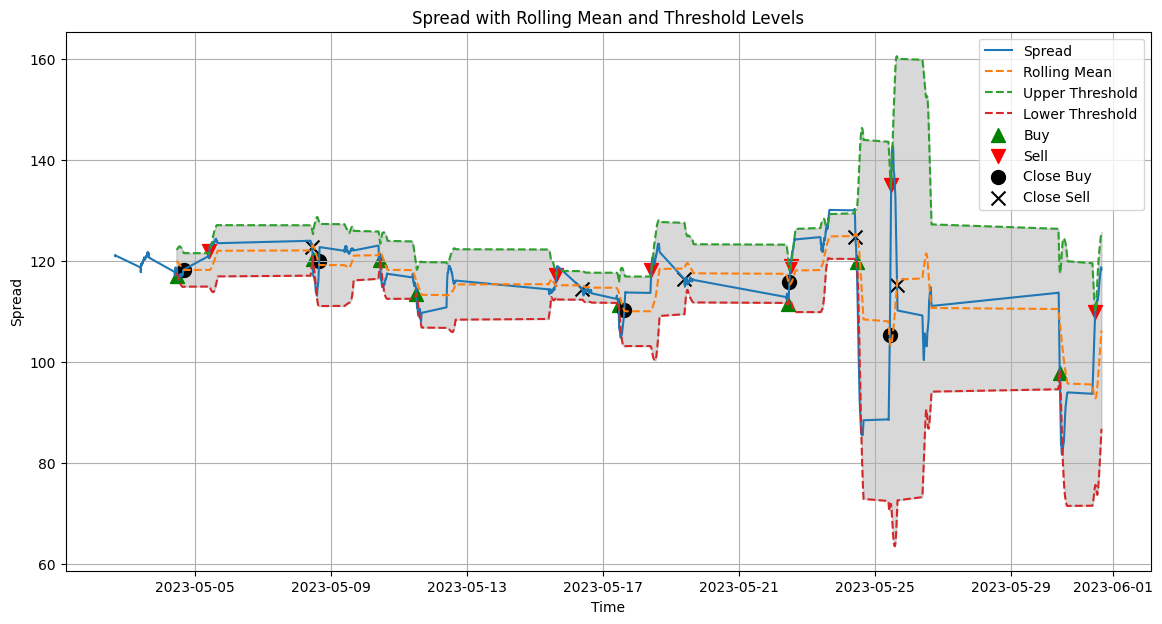

8 ('NKE', 'TGT')


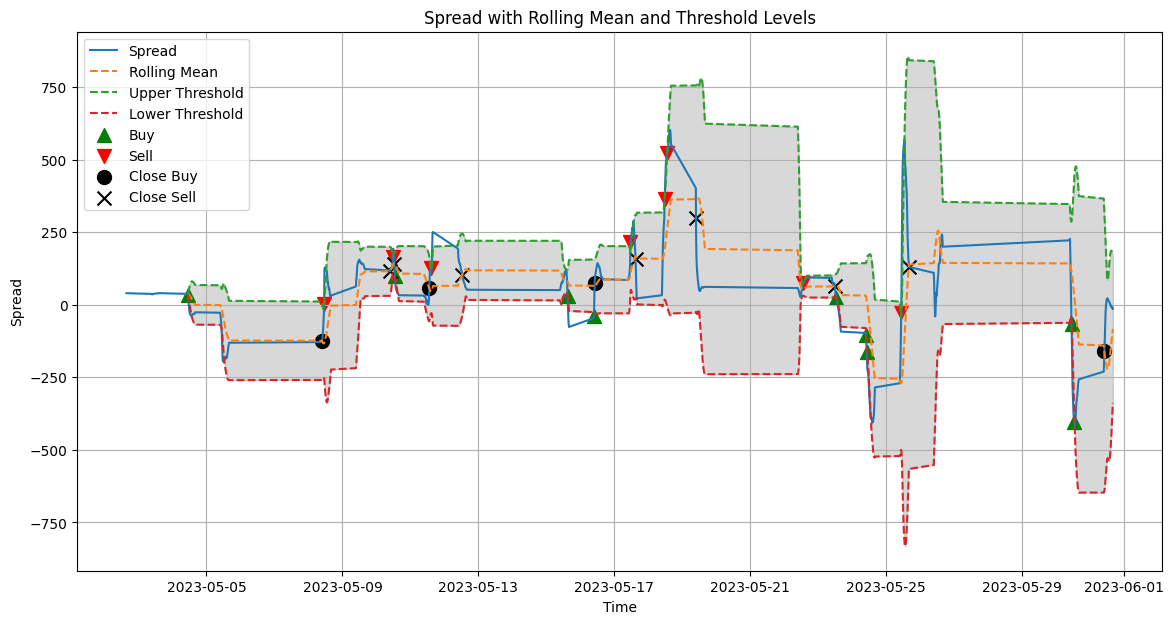

9 ('NKE', 'VZ')


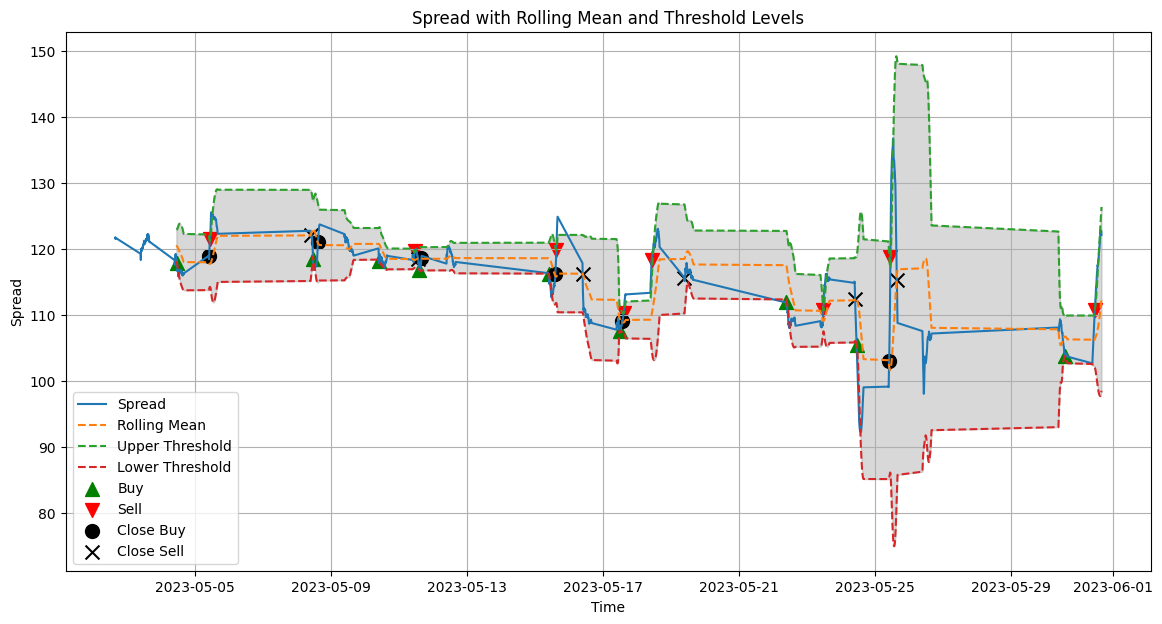

Monthly Trade Metrics:
Average Trade Return: 0.5863361279993582
Standard Deviation of Trade Returns: 13.489999499349329
Sharpe Ratio: 0.6899775998303019
Cumulative Return: 0.0


KeyboardInterrupt: Interrupted by user

In [18]:
data = prices[-15000:-5000]
monthly_results = []

# Prepare data
for year, month, monthly_data in yield_monthly_data(data):
    print(f"Clustering for {month} {year}")
    cluster = calculate_monthly_clusters(monthly_data)
    data = data.dropna(axis=1)
    next_month_data = generate_trading_data_blocks(data, month, year)

    # Get pairs on first 500 data points
    pairs = get_coint_pairs(next_month_data[:500], cluster)

    combined_trades_df = pd.DataFrame()

    for i, pair in zip(range(min(len(pairs[:10]), len(pairs))), pairs):
        print(i, pair)

        agent = TradingAgent()

        result_df = agent.process_pair(pair, next_month_data[150:])
        result_df, trades_df = agent.trade(result_df)
        combined_trades_df = pd.concat([combined_trades_df, trades_df])

        agent.visualize_spread(result_df)

        # input(combined_trades_df)

    # Sort combined trades by datetime index
    combined_trades_df.sort_index(inplace=True)

    # Calculate metrics for the month
    metrics = agent.calculate_metrics(combined_trades_df)

    print("Monthly Trade Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value}")

    monthly_results.append(combined_trades_df)

    input(combined_trades_df)

    plt.show()


In [ ]:
data = prices[-15000:-5000]

# prepare data
for year, month, monthly_data in yield_monthly_data(data):
    print(f"Clustering for {month} {year}")
    cluster = calculate_monthly_clusters(monthly_data)
    data = data.dropna(axis=1)
    next_month_data = generate_trading_data_blocks(data, month, year)

    #get pairs on first 500 data points
    pairs = get_coint_pairs(next_month_data[:500], cluster)


    for i,pair in zip(range(min(len(pairs[:10]),len(pairs))),pairs):
      print(i,pair)

      # df = process_pair(pair, next_month_data[150:])
      agent = TradingAgent()

      result_df = agent.process_pair(pair, next_month_data[150:])
      result_df = agent.trade(result_df)
      agent.visualize_spread(result_df)
      (result_df["capital"]).plot()
      metrics = agent.calculate_metrics(result_df)

      print("Trade Metrics:")
      for key, value in metrics.items():
          print(f"{key}: {value}")
      plt.show()


In [16]:
class TradingAgent:
    def __init__(self, initial_capital=100000):
        self.initial_capital = initial_capital
        self.per_pair_capital = initial_capital

    def calculate_hedge_ratio(self, x, y):
        x = sm.add_constant(x)  # Adding a constant term for the intercept
        model = sm.OLS(y, x).fit()
        return model.params[1]  # Return the coefficient of x, which is the hedge ratio

    def process_pair(self, pair, prices, window=100):
        s1, s2 = pair
        datax = prices[s1]
        datay = prices[s2]

        hedge_ratios = []
        for start in range(len(datax) - window + 1):
            end = start + window
            x_window = datax[start:end]
            y_window = datay[start:end]
            hedge_ratio = self.calculate_hedge_ratio(x_window, y_window)
            hedge_ratios.append(hedge_ratio)

        hedge_ratios = pd.Series(hedge_ratios, index=datax.index[window-1:])
        hedge_ratios = hedge_ratios.reindex(datax.index).fillna(method='bfill')

        spread = datax - hedge_ratios * datay
        rolling_mean = spread.rolling(window=window).mean()
        rolling_std = spread.rolling(window=window).std()
        upper_threshold_level = rolling_mean + 2 * rolling_std
        lower_threshold_level = rolling_mean - 2 * rolling_std

        result_df = pd.DataFrame({
            's1': datax,
            's2': datay,
            'spread': spread,
            'hedge_ratios': hedge_ratios,
            'rolling_mean': rolling_mean,
            'upper_threshold_level': upper_threshold_level,
            'lower_threshold_level': lower_threshold_level
        })

        result_df['returns'] = 0.0
        result_df['returns_pct'] = 0.0
        result_df['capital'] = self.initial_capital
        result_df['action'] = np.nan
        result_df['pair'] = f"{s1}/{s2}"

        return result_df

    def trade(self, result_df):
        capital = self.initial_capital
        positions = 0
        entry_spread = 0
        entry_s1 = 0
        entry_s2 = 0
        entry_qty_s1 = 0
        entry_qty_s2 = 0
        last_capital_update_index = 0
        stop_loss_threshold = 0.01  # 1% stop loss

        result_df['returns'] = 0.0
        result_df['returns_pct'] = 0.0
        result_df['capital'] = capital
        result_df['cap_ret'] = 0.0

        trades = []

        for i in range(1, len(result_df)):  # Start from the second row
            # Update capital for all rows till the current row
            if i > last_capital_update_index:
                result_df.loc[result_df.index[last_capital_update_index:i], 'capital'] = capital

            # Calculate the required capital to trade one pair
            hedge_ratio = abs(result_df['hedge_ratios'].iloc[i])
            required_capital_per_pair = (result_df['s1'].iloc[i] + hedge_ratio * result_df['s2'].iloc[i])

            # Calculate the maximum quantity that can be traded based on available capital
            max_qty = self.per_pair_capital // required_capital_per_pair

            if positions == 0:
                if result_df['spread'].iloc[i] > result_df['upper_threshold_level'].iloc[i]:
                    positions = -1  # Sell position
                    entry_spread = result_df['spread'].iloc[i]
                    entry_s1 = result_df['s1'].iloc[i]
                    entry_s2 = result_df['s2'].iloc[i]
                    entry_qty_s1 = max_qty
                    entry_qty_s2 = max_qty * hedge_ratio
                    result_df.at[result_df.index[i], 'action'] = 'Sell'
                    last_capital_update_index = i
                elif result_df['spread'].iloc[i] < result_df['lower_threshold_level'].iloc[i]:
                    positions = 1  # Buy position
                    entry_spread = result_df['spread'].iloc[i]
                    entry_s1 = result_df['s1'].iloc[i]
                    entry_s2 = result_df['s2'].iloc[i]
                    entry_qty_s1 = max_qty
                    entry_qty_s2 = max_qty * hedge_ratio
                    result_df.at[result_df.index[i], 'action'] = 'Buy'
                    last_capital_update_index = i

            elif positions == -1:
                if result_df['spread'].iloc[i] <= result_df['rolling_mean'].iloc[i]:
                    # Calculate returns for sell position
                    returns = (entry_qty_s1 * (entry_s1 - result_df['s1'].iloc[i]) -
                               entry_qty_s2 * (result_df['s2'].iloc[i] - entry_s2))
                    returns_pct = returns / required_capital_per_pair
                    capital += returns
                    result_df.at[result_df.index[i], 'returns'] = returns
                    result_df.at[result_df.index[i], 'returns_pct'] = returns_pct
                    result_df.at[result_df.index[i], 'capital'] = capital
                    result_df.at[result_df.index[i], 'action'] = 'Close Sell'
                    positions = 0  # Close position
                    last_capital_update_index = i
                    trades.append(result_df.iloc[i].copy())
                else:
                    # Check stop loss for sell position
                    loss = (entry_qty_s1 * (result_df['s1'].iloc[i] - entry_s1) +
                            entry_qty_s2 * (entry_s2 - result_df['s2'].iloc[i]))
                    if loss >= stop_loss_threshold * self.per_pair_capital:
                        capital -= loss
                        returns_pct = -loss / required_capital_per_pair
                        result_df.at[result_df.index[i], 'returns'] = -loss
                        result_df.at[result_df.index[i], 'returns_pct'] = returns_pct
                        result_df.at[result_df.index[i], 'capital'] = capital
                        result_df.at[result_df.index[i], 'action'] = 'Stop Loss Sell'
                        positions = 0  # Close position due to stop loss
                        last_capital_update_index = i
                        trades.append(result_df.iloc[i].copy())

            elif positions == 1:
                if result_df['spread'].iloc[i] >= result_df['rolling_mean'].iloc[i]:
                    # Calculate returns for buy position
                    returns = (entry_qty_s1 * (result_df['s1'].iloc[i] - entry_s1) +
                               entry_qty_s2 * (result_df['s2'].iloc[i] - entry_s2))
                    returns_pct = returns / required_capital_per_pair
                    capital += returns
                    result_df.at[result_df.index[i], 'returns'] = returns
                    result_df.at[result_df.index[i], 'returns_pct'] = returns_pct
                    result_df.at[result_df.index[i], 'capital'] = capital
                    result_df.at[result_df.index[i], 'action'] = 'Close Buy'
                    positions = 0  # Close position
                    last_capital_update_index = i
                    trades.append(result_df.iloc[i].copy())
                else:
                    # Check stop loss for buy position
                    loss = (entry_qty_s1 * (entry_s1 - result_df['s1'].iloc[i]) +
                            entry_qty_s2 * (entry_s2 - result_df['s2'].iloc[i]))
                    if loss >= stop_loss_threshold * self.per_pair_capital:
                        capital -= loss
                        returns_pct = -loss / required_capital_per_pair
                        result_df.at[result_df.index[i], 'returns'] = -loss
                        result_df.at[result_df.index[i], 'returns_pct'] = returns_pct
                        result_df.at[result_df.index[i], 'capital'] = capital
                        result_df.at[result_df.index[i], 'action'] = 'Stop Loss Buy'
                        positions = 0  # Close position due to stop loss
                        last_capital_update_index = i
                        trades.append(result_df.iloc[i].copy())

        # Update capital for the remaining rows
        result_df.loc[result_df.index[last_capital_update_index:], 'capital'] = capital

        # Calculate cumulative return on initial capital
        result_df['cap_ret'] = result_df['capital'] / self.initial_capital - 1

        trades_df = pd.DataFrame(trades)
        return result_df, trades_df


    def visualize_spread(self, result_df):
        plt.figure(figsize=(14, 7))

        plt.plot(result_df.index, result_df['spread'], label='Spread')
        plt.plot(result_df.index, result_df['rolling_mean'], label='Rolling Mean', linestyle='--')
        plt.plot(result_df.index, result_df['upper_threshold_level'], label='Upper Threshold', linestyle='--')
        plt.plot(result_df.index, result_df['lower_threshold_level'], label='Lower Threshold', linestyle='--')

        plt.fill_between(result_df.index, result_df['upper_threshold_level'], result_df['lower_threshold_level'], color='grey', alpha=0.3)

        # Add markers for actions
        buys = result_df[result_df['action'] == 'Buy']
        sells = result_df[result_df['action'] == 'Sell']
        close_buys = result_df[result_df['action'] == 'Close Buy']
        close_sells = result_df[result_df['action'] == 'Close Sell']

        plt.scatter(buys.index, buys['spread'] + 0.02, color='green', marker='^', s=100, label='Buy')  # Offset buys
        plt.scatter(sells.index, sells['spread'] - 0.02, color='red', marker='v', s=100, label='Sell')  # Offset sells
        plt.scatter(close_buys.index, close_buys['spread'], color='black', marker='o', s=100, label='Close Buy')
        plt.scatter(close_sells.index, close_sells['spread'], color='black', marker='x', s=100, label='Close Sell')

        plt.title('Spread with Rolling Mean and Threshold Levels')
        plt.xlabel('Time')
        plt.ylabel('Spread')
        plt.legend()
        plt.grid(True)
        plt.show()

    def calculate_metrics(self, combined_trades_df):
        if combined_trades_df.empty:
            return None

        # Filter out the rows where trades were closed
        closed_trades = combined_trades_df[combined_trades_df['action'].isin(['Close Buy', 'Close Sell', 'Stop Loss Buy', 'Stop Loss Sell'])]

        if closed_trades.empty:
            return None

        # Calculate the returns on closed trades
        trade_returns = closed_trades['returns_pct']

        # Calculate the average return per trade
        avg_trade_return = trade_returns.mean()

        # Calculate the standard deviation of returns per trade
        std_trade_return = trade_returns.std()

        # Calculate the Sharpe ratio
        if std_trade_return != 0:
            sharpe_ratio = (avg_trade_return / std_trade_return) * np.sqrt(252)  # Assuming 252 trading days in a year
        else:
            sharpe_ratio = np.nan

        # Calculate cumulative returns
        cumulative_return = combined_trades_df['cap_ret'].iloc[-1]

        metrics = {
            'Average Trade Return': avg_trade_return,
            'Standard Deviation of Trade Returns': std_trade_return,
            'Sharpe Ratio': sharpe_ratio,
            'Cumulative Return': cumulative_return
        }

        return metrics


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

class TradingAgent:
    def __init__(self, initial_capital=100000):
        self.initial_capital = initial_capital
        self.per_pair_capital = initial_capital

    def calculate_hedge_ratio(self, x, y):
        x = sm.add_constant(x)  # Adding a constant term for the intercept
        model = sm.OLS(y, x).fit()
        return model.params[1]  # Return the coefficient of x, which is the hedge ratio


    def process_pair(self, pair, prices, window=100):
        s1, s2 = pair
        datax = prices[s1]
        datay = prices[s2]

        hedge_ratios = []
        for start in range(len(datax) - window + 1):
            end = start + window
            x_window = datax[start:end]
            y_window = datay[start:end]
            hedge_ratio = self.calculate_hedge_ratio(x_window, y_window)
            hedge_ratios.append(hedge_ratio)

        hedge_ratios = pd.Series(hedge_ratios, index=datax.index[window-1:])
        hedge_ratios = hedge_ratios.reindex(datax.index).fillna(method='bfill')

        spread = datax - hedge_ratios * datay
        rolling_mean = spread.rolling(window=window).mean()
        rolling_std = spread.rolling(window=window).std()
        upper_threshold_level = rolling_mean + 2 * rolling_std
        lower_threshold_level = rolling_mean - 2 * rolling_std

        result_df = pd.DataFrame({
            's1': datax,
            's2': datay,
            'spread': spread,
            'hedge_ratios': hedge_ratios,
            'rolling_mean': rolling_mean,
            'upper_threshold_level': upper_threshold_level,
            'lower_threshold_level': lower_threshold_level
        })

        result_df['returns'] = np.nan
        result_df['capital'] = self.initial_capital
        result_df['action'] = np.nan

        return result_df


    def trade(self, result_df):
        capital = self.initial_capital
        positions = 0
        entry_spread = 0
        entry_s1 = 0
        entry_s2 = 0
        last_capital_update_index = 0

        result_df['returns'] = 0.0
        result_df['capital'] = capital
        result_df['cap_ret'] = 0.0

        for i in range(1, len(result_df)):  # Start from the second row
            # Update capital for all rows till the current row
            if i > last_capital_update_index:
                result_df.loc[result_df.index[last_capital_update_index:i], 'capital'] = capital

            # Calculate the required capital to trade one pair
            required_capital_per_pair = (result_df['s1'].iloc[i] + abs(result_df['hedge_ratios'].iloc[i]) * result_df['s2'].iloc[i])

            # Calculate the maximum quantity that can be traded based on available capital
            max_qty = self.per_pair_capital // required_capital_per_pair

            if positions == 0:
                if result_df['spread'].iloc[i] > result_df['upper_threshold_level'].iloc[i]:
                    positions = -1  # Sell position
                    entry_spread = result_df['spread'].iloc[i]
                    entry_s1 = result_df['s1'].iloc[i]
                    entry_s2 = result_df['s2'].iloc[i]
                    entry_qty = max_qty
                    result_df.at[result_df.index[i], 'action'] = 'Sell'
                    last_capital_update_index = i
                elif result_df['spread'].iloc[i] < result_df['lower_threshold_level'].iloc[i]:
                    positions = 1  # Buy position
                    entry_spread = result_df['spread'].iloc[i]
                    entry_s1 = result_df['s1'].iloc[i]
                    entry_s2 = result_df['s2'].iloc[i]
                    entry_qty = max_qty
                    result_df.at[result_df.index[i], 'action'] = 'Buy'
                    last_capital_update_index = i

            elif positions == -1:
                if result_df['spread'].iloc[i] <= result_df['rolling_mean'].iloc[i]:
                    # Calculate percentage change in spread
                    spread_pct_change = (entry_spread - result_df['spread'].iloc[i]) / entry_spread
                    returns = entry_qty * required_capital_per_pair * spread_pct_change
                    capital += returns
                    result_df.at[result_df.index[i], 'returns'] = returns
                    result_df.at[result_df.index[i], 'capital'] = capital
                    result_df.at[result_df.index[i], 'action'] = 'Close Sell'
                    positions = 0  # Close position
                    last_capital_update_index = i

            elif positions == 1:
                if result_df['spread'].iloc[i] >= result_df['rolling_mean'].iloc[i]:
                    # Calculate percentage change in spread
                    spread_pct_change = (result_df['spread'].iloc[i] - entry_spread) / entry_spread
                    returns = entry_qty * required_capital_per_pair * spread_pct_change
                    capital += returns
                    result_df.at[result_df.index[i], 'returns'] = returns
                    result_df.at[result_df.index[i], 'capital'] = capital
                    result_df.at[result_df.index[i], 'action'] = 'Close Buy'
                    positions = 0  # Close position
                    last_capital_update_index = i

        # Update capital for the remaining rows
        result_df.loc[result_df.index[last_capital_update_index:], 'capital'] = capital

        # Calculate cumulative return on initial capital
        result_df['cap_ret'] = result_df['capital'] / self.initial_capital - 1

        return result_df


    def visualize_spread(self, result_df):
        plt.figure(figsize=(14, 7))

        result_df.reset_index(inplace=True)

        plt.plot(result_df.index, result_df['spread'], label='Spread')
        plt.plot(result_df.index, result_df['rolling_mean'], label='Rolling Mean', linestyle='--')
        plt.plot(result_df.index, result_df['upper_threshold_level'], label='Upper Threshold', linestyle='--')
        plt.plot(result_df.index, result_df['lower_threshold_level'], label='Lower Threshold', linestyle='--')

        plt.fill_between(result_df.index, 2, -2, color='grey', alpha=0.3)

        # Add markers for actions
        buys = result_df[result_df['action'] == 'Buy']
        sells = result_df[result_df['action'] == 'Sell']
        close_buys = result_df[result_df['action'] == 'Close Buy']
        close_sells = result_df[result_df['action'] == 'Close Sell']

        plt.scatter(buys.index, buys['spread'], color='green', marker='^', s=100, label='Buy')
        plt.scatter(sells.index, sells['spread'], color='red', marker='v', s=100, label='Sell')
        plt.scatter(close_buys.index, close_buys['spread'], color='black', marker='o', s=100, label='Close Buy')
        plt.scatter(close_sells.index, close_sells['spread'], color='black', marker='x', s=100, label='Close Sell')

        plt.title('Spread with Rolling Mean and Threshold Levels')
        plt.xlabel('Time')
        plt.ylabel('Spread')
        plt.legend()
        plt.grid(True)
        plt.show()
